In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm.notebook import tqdm
import json

In [35]:
# get data from processed data dir
data_dir = '../processed_data/antsYmaze_ABCD-GNL_EFGH-GFL-17Nov23_2023_11_17_17_55_39'
# get all cam numbers
cams = [x.split('_')[0] for x in os.listdir(data_dir)]
cams = np.unique(cams)
print(cams)

['cam0' 'cam1' 'cam2' 'cam3' 'cam4' 'cam5' 'cam6' 'cam7']


In [36]:
# cam to expriment+identifier
cam_to_exp = {
    'cam0':'H',
    'cam1':'C',
    'cam2':'B',
    'cam3':'E',
    'cam4':'D',
    'cam5':'A',
    'cam6':'F',
    'cam7':'G'
}
exceptions = [
    # 'D', 3, 'kwiksil vs food vs empty',
    ## NEED TO REMOVE WHERE ANT MANAGED TO FREE THE LARVAE
]

def get_experiment_name(cam, arena):
    # if cam is A, B, C, D ->larvae kwiksil control
    # if cam is E, F, G, H -> larvae food experiment
    name = ""
    if cam_to_exp[cam] in ['A','B','C','D']:
        name += 'glue vs nothing vs larvae'
    else:
        name += 'glue vs food vs larvae'

    # cycle at the end of list
    for cam_override, arena_override, name_override in exceptions:
        if cam_to_exp[cam] == cam_override and arena == arena_override:
            name = name_override
    return name

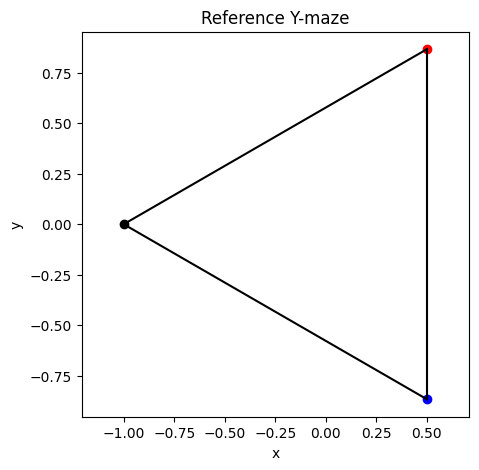

In [37]:
# generate reference ymaze
point_a = np.array([-1, 0]) # first point
point_b = np.array([np.cos(np.pi/3), np.sin(np.pi/3)]) # second point
point_c = np.array([np.cos(-np.pi/3), np.sin(-np.pi/3)]) # third point
# plot reference ymaze
plt.figure(figsize=(5,5))
plt.plot(point_a[0], point_a[1], 'o', color='black')
plt.plot(point_b[0], point_b[1], 'o', color='red')
plt.plot(point_c[0], point_c[1], 'o', color='blue')
plt.plot([point_a[0], point_b[0]], [point_a[1], point_b[1]], color='black')
plt.plot([point_a[0], point_c[0]], [point_a[1], point_c[1]], color='black')
plt.plot([point_b[0], point_c[0]], [point_b[1], point_c[1]], color='black')
plt.axis('equal')
plt.title('Reference Y-maze')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
# generate reference points
reference_points = np.array([point_a, point_b, point_c])

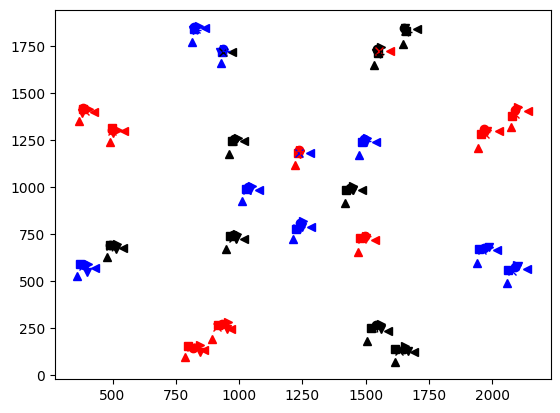

In [38]:
markers = ['o', 's', '^', 'v', '<', '>', 'x', '+']
for i in range(8):
    with open(data_dir+f'/cam{i}_background_endpoints.json') as f:
        endpoints = json.load(f)
    for arena in range(8):
        endpoint = endpoints[f'arena_{arena+1}_original']
        plt.plot(endpoint[0][0], endpoint[0][1], 'k', marker=markers[i])
        plt.plot(endpoint[1][0], endpoint[1][1], 'r', marker=markers[i])
        plt.plot(endpoint[2][0], endpoint[2][1], 'b', marker=markers[i])
    # plt.show()

In [82]:
from skimage.transform import estimate_transform, AffineTransform
rotate_by_120 = AffineTransform(rotation=2*np.pi/3)
rotate_by_240 = AffineTransform(rotation=4*np.pi/3)
# project to reference
def project_to_reference(endpoints, xs, ys):
    # convert to numpy array
    endpoints = np.array(endpoints)
    # estimate transform to reference
    transform = estimate_transform('affine', endpoints, reference_points)
    # project to reference
    projected = transform(np.array([xs, ys]).T)
    return projected
# project to arm coordinates
def project_to_arm(projected):
    # rotate by 0
    arm1 = -np.clip(projected[:,0], -1, 0)
    # rotate by 120
    projected = rotate_by_120(projected)
    arm2 = -np.clip(projected[:,0], -1, 0)
    # rotate by 240
    projected = rotate_by_120(projected)
    arm3 = -np.clip(projected[:,0], -1, 0)
    # final coordinates
    projected = np.array([arm1, arm2, arm3]).T
    return projected

In [83]:
# get endpoints
ALL_DATA = {}
ALL_COORDS = {}
ALL_IDS = {}
ALL_POIS = {}
for camera in range(8):
    with open(data_dir+f'/cam{camera}_background_endpoints.json') as f:
        endpoints = json.load(f)
    with open(data_dir+f'/cam{camera}_background_pois.json') as f:
        pois = json.load(f)
    # get ant locations
    locations = pd.read_csv(data_dir+f'/cam{camera}_ant_locations.csv')
    for arena in tqdm(range(8), desc=f'cam{camera}, all arenas'):
        # get experiment name
        experiment_name = get_experiment_name(f'cam{camera}', arena)
        if experiment_name not in ALL_DATA:
            ALL_DATA[experiment_name] = []
        if experiment_name not in ALL_POIS:
            ALL_POIS[experiment_name] = []
        if experiment_name not in ALL_IDS:
            ALL_IDS[experiment_name] = []
        if experiment_name not in ALL_COORDS:
            ALL_COORDS[experiment_name] = []

        
        # get endpoint
        endpoint = endpoints[f"arena_{arena+1}_original"]

        # get ant locations
        ant_x = locations[f"arena_{arena+1}_x"]
        ant_y = locations[f"arena_{arena+1}_y"]

        # get poi
        poi = pois[f'arena_{arena+1}_original']
        poi = np.array(poi)

        # get projected locations
        projections = project_to_reference(endpoint, ant_x, ant_y)

        # get projected coordinates
        coords = project_to_arm(projections)

        # project the poi
        poises = project_to_reference(endpoint, poi[:,0], poi[:,1])

        # add to ALL_DATA
        ALL_DATA[experiment_name].append(projections)
        ALL_COORDS[experiment_name].append(coords)
        ALL_IDS[experiment_name].append((f'Camera {camera}', 'Exp '+cam_to_exp[f'cam{camera}'], f'Arena {arena+1}'))
        ALL_POIS[experiment_name].append(poises)
    

cam0, all arenas:   0%|          | 0/8 [00:00<?, ?it/s]

cam1, all arenas:   0%|          | 0/8 [00:00<?, ?it/s]

cam2, all arenas:   0%|          | 0/8 [00:00<?, ?it/s]

cam3, all arenas:   0%|          | 0/8 [00:00<?, ?it/s]

cam4, all arenas:   0%|          | 0/8 [00:00<?, ?it/s]

cam5, all arenas:   0%|          | 0/8 [00:00<?, ?it/s]

cam6, all arenas:   0%|          | 0/8 [00:00<?, ?it/s]

cam7, all arenas:   0%|          | 0/8 [00:00<?, ?it/s]

In [84]:
ALL_DATA.keys()

dict_keys(['glue vs food vs larvae', 'glue vs nothing vs larvae'])

In [85]:
rotate_by_90 = AffineTransform(rotation=np.pi/2)

def coordinate_histogram(coords, dt, N, ids=None, bin_size=10, EPS=1e-6, plot_hist=True, show_legend=True, figsize=(5,5),save_path=None, show_velocity=False):
    arm1 = coords[:,0]
    arm2 = coords[:,1]
    arm3 = coords[:,2]

    vels = np.diff(np.sum(coords, axis=1))/dt
    vels = np.concatenate([[0], vels])
    vels = np.abs(vels)

    arm_vels = np.zeros_like(coords)
    arm_vels[:,0][arm1>EPS] = vels[arm1>EPS]
    arm_vels[:,1][arm2>EPS] = vels[arm2>EPS]
    arm_vels[:,2][arm3>EPS] = vels[arm3>EPS]

    # get binned arms
    bins = np.linspace(EPS,1,bin_size+1)
    binned_arm1 = np.histogram(arm1, bins=bins)[0]*dt/N
    binned_arm2 = np.histogram(arm2, bins=bins)[0]*dt/N
    binned_arm3 = np.histogram(arm3, bins=bins)[0]*dt/N

    max_value = np.max([binned_arm1, binned_arm2, binned_arm3])
    # round to nearest 10
    max_value = np.ceil(max_value/10)*10
    
    distance = (bins[1]-bins[0])/2
    binned_arm1, binned_arm2, binned_arm3 = binned_arm1/max_value, binned_arm2/max_value, binned_arm3/max_value

    # get binned arm velocities
    binned_arm1_vels, binned_arm2_vels, binned_arm3_vels = [], [], []
    for i,j in zip(bins[:-1], bins[1:]):
        binned_arm1_vels.append(np.mean(arm_vels[:,0][(arm1>i) & (arm1<j)]))
        binned_arm2_vels.append(np.mean(arm_vels[:,1][(arm2>i) & (arm2<j)]))
        binned_arm3_vels.append(np.mean(arm_vels[:,2][(arm3>i) & (arm3<j)]))

    binned_arm1_vels, binned_arm2_vels, binned_arm3_vels = np.array(binned_arm1_vels), np.array(binned_arm2_vels), np.array(binned_arm3_vels)

    max_vel = np.max([binned_arm1_vels, binned_arm2_vels, binned_arm3_vels])

    binned_arm1_vels, binned_arm2_vels, binned_arm3_vels = binned_arm1_vels/max_vel, binned_arm2_vels/max_vel, binned_arm3_vels/max_vel

    # length vals
    length_vals = np.linspace(EPS, 1, 2*bin_size+1)[1::2]

    fig,ax = plt.subplots(figsize=figsize)
    scale_factor = np.mean(figsize)/5

    # arm vectors
    arm1_vec = np.array([-1, 0])
    arm1_vel_vec = rotate_by_90(arm1_vec)
    ax.plot([0,arm1_vec[0]], [0,arm1_vec[1]], color='white', zorder=0, linewidth=0.5)
    arm1_vecs= np.dot(arm1_vec.reshape(2,1), length_vals.reshape(1,bin_size)).T

    arm2_vec = np.array([np.cos(np.pi/3), np.sin(np.pi/3)])
    arm2_vel_vec = rotate_by_90(arm2_vec)
    ax.plot([0,arm2_vec[0]], [0,arm2_vec[1]], color='white', zorder=0, linewidth=0.5)
    arm2_vecs = np.dot(arm2_vec.reshape(2,1), length_vals.reshape(1,bin_size)).T

    arm3_vec = np.array([np.cos(-np.pi/3), np.sin(-np.pi/3)])
    arm3_vel_vec = rotate_by_90(arm3_vec)
    ax.plot([0,arm3_vec[0]], [0,arm3_vec[1]], color='white', zorder=0, linewidth=0.5)
    arm3_vecs = np.dot(arm3_vec.reshape(2,1), length_vals.reshape(1,bin_size)).T

    for i in range(bin_size):
        # use pylab to plot circles
        c = plt.Circle((arm1_vecs[i,0], arm1_vecs[i,1]), radius = np.sqrt(binned_arm1[i])*distance, color=plt.cm.tab10(0.0), fill=True, zorder=1)
        ax.add_patch(c)
        c = plt.Circle((arm2_vecs[i,0], arm2_vecs[i,1]), radius = np.sqrt(binned_arm2[i])*distance, color=plt.cm.tab10(0.1), fill=True, zorder=1)
        ax.add_patch(c)
        c = plt.Circle((arm3_vecs[i,0], arm3_vecs[i,1]), radius = np.sqrt(binned_arm3[i])*distance, color=plt.cm.tab10(0.2), fill=True, zorder=1)
        ax.add_patch(c)
    
    if show_velocity:
        for i in range(bin_size):
            # use pylab to plot circles
            c = plt.Circle((arm1_vecs[i,0] + 0.1 * arm1_vel_vec[0,0], arm1_vecs[i,1] + 0.1 * arm1_vel_vec[0,1]), radius = np.sqrt(binned_arm1_vels[i])*distance, color='white', fill=True, zorder=1)
            ax.add_patch(c)
            c = plt.Circle((arm2_vecs[i,0] + 0.1 * arm2_vel_vec[0,0], arm2_vecs[i,1] + 0.1 * arm2_vel_vec[0,1]), radius = np.sqrt(binned_arm2_vels[i])*distance, color='white', fill=True, zorder=1)
            ax.add_patch(c)
            c = plt.Circle((arm3_vecs[i,0] + 0.1 * arm3_vel_vec[0,0], arm3_vecs[i,1] + 0.1 * arm3_vel_vec[0,1]), radius = np.sqrt(binned_arm3_vels[i])*distance, color='white', fill=True, zorder=1)
            ax.add_patch(c)
    
    if show_legend:
        # generate circle for legend
        if not show_velocity:
            c = plt.Circle((-.75,.75), radius = distance, color='white', fill=True)
            ax.add_patch(c)
            ax.text(-0.45, .75, f'{max_value:.0f}mins', horizontalalignment='center', verticalalignment='center', fontsize=12*scale_factor, color=plt.cm.tab10(0.0))
            c = plt.Circle((-.75,.60), radius = (0.5)**0.5*distance, color='white', fill=True)
            ax.add_patch(c)
            ax.text(-0.45, .60, f'{max_value/2:.0f}mins', horizontalalignment='center', verticalalignment='center', fontsize=12*scale_factor, color=plt.cm.tab10(0.1))
            c = plt.Circle((-.75,.45), radius = (0.25)**0.5*distance, color='white', fill=True)
            ax.add_patch(c)
            ax.text(-0.45, .45, f'{max_value/4:.0f}mins', horizontalalignment='center', verticalalignment='center', fontsize=12*scale_factor, color=plt.cm.tab10(0.2))
        else:
            c = plt.Circle((-.95,.75), radius = distance, color='white', fill=True)
            ax.add_patch(c)
            ax.text(-0.70, .75, f'{max_value:.0f}mins', horizontalalignment='center', verticalalignment='center', fontsize=12*scale_factor, color=plt.cm.tab10(0.0))
            ax.text(-0.30, .75, f'{max_vel*20/60:.2f}mm/s', horizontalalignment='center', verticalalignment='center', fontsize=12*scale_factor, color='white')
            c = plt.Circle((-.95,.60), radius = (0.5)**0.5*distance, color='white', fill=True)
            ax.add_patch(c)
            ax.text(-0.70, .60, f'{max_value/2:.0f}mins', horizontalalignment='center', verticalalignment='center', fontsize=12*scale_factor, color=plt.cm.tab10(0.1))
            ax.text(-0.30, .60, f'{max_vel*10/60:.2f}mm/s', horizontalalignment='center', verticalalignment='center', fontsize=12*scale_factor, color='white')
            c = plt.Circle((-.95,.45), radius = (0.25)**0.5*distance, color='white', fill=True)
            ax.add_patch(c)
            ax.text(-0.70, .45, f'{max_value/4:.0f}mins', horizontalalignment='center', verticalalignment='center', fontsize=12*scale_factor, color=plt.cm.tab10(0.2))
            ax.text(-0.30, .45, f'{max_vel*5/60:.2f}mm/s', horizontalalignment='center', verticalalignment='center', fontsize=12*scale_factor, color='white')
            
        


    
    if ids is not None:
        assert len(ids) == 3, "ids must be a list of 3 for each arm"
        ds = 1.15
        ax.text(arm1_vec[0]*ds, arm1_vec[1]*ds, ids[0], horizontalalignment='center', verticalalignment='center', color=plt.cm.tab10(0.0), fontsize=16*scale_factor)
        ax.text(arm2_vec[0]*ds, arm2_vec[1]*ds, ids[1], horizontalalignment='center', verticalalignment='center', color=plt.cm.tab10(0.1), fontsize=16*scale_factor)
        ax.text(arm3_vec[0]*ds, arm3_vec[1]*ds, ids[2], horizontalalignment='center', verticalalignment='center', color=plt.cm.tab10(0.2), fontsize=16*scale_factor)
    
    ax.axis('equal')
    ax.axis('off')
    
    # create inset axes
    if plot_hist:
        axins = ax.inset_axes([0.15, 0.05, 0.5, 0.25])
        axins.step(np.linspace(0,1,bin_size+2), np.concatenate([[0], binned_arm1*max_value, [0]]), color=plt.cm.tab10(0.0))
        axins.step(np.linspace(0,1,bin_size+2), np.concatenate([[0], binned_arm2*max_value, [0]]), color=plt.cm.tab10(0.1))
        axins.step(np.linspace(0,1,bin_size+2), np.concatenate([[0], binned_arm3*max_value, [0]]), color=plt.cm.tab10(0.2))
        axins.set_xlim(0,1)
        axins.set_xlabel('Distance from center (a.u.)', fontsize=10*scale_factor, color='white')
        axins.set_ylabel('Time spent (mins)', fontsize=10*scale_factor, color='white')
        axins.set_xticks([0,1])
        axins.set_xticklabels(['0', '1'], color='white', fontsize=8*scale_factor)
        axins.set_yticks([0, max_value/2, max_value])
        axins.set_yticklabels(['0', f'{max_value/2:.0f}', f'{max_value:.0f}'], color='white', fontsize=8*scale_factor)
        axins.set_facecolor('None')
        axins.spines['bottom'].set_color('white')
        axins.spines['left'].set_color('white')
        axins.spines['top'].set_visible(False)
        axins.spines['right'].set_visible(False)
        if show_velocity:
            axins2 = ax.inset_axes([0.275, 0.175, 0.15, 0.175])
            axins2.step(np.linspace(0,1,bin_size+2), np.concatenate([[0], binned_arm1_vels*max_vel*20/60, [0]]), color=plt.cm.tab10(0.0))
            axins2.step(np.linspace(0,1,bin_size+2), np.concatenate([[0], binned_arm2_vels*max_vel*20/60, [0]]), color=plt.cm.tab10(0.1))
            axins2.step(np.linspace(0,1,bin_size+2), np.concatenate([[0], binned_arm3_vels*max_vel*20/60, [0]]), color=plt.cm.tab10(0.2))
            axins2.set_xlim(0,1)
            axins2.set_ylabel('Velocity (mm/s)', fontsize=8*scale_factor, color='white')
            axins2.set_xticks([0,1])
            axins2.set_xticklabels(['0', '1'], color='white', fontsize=8*scale_factor)
            axins2.set_yticks([0, max_vel*10/60, max_vel*20/60])
            axins2.set_yticklabels(['0', f'{max_vel*10/60:.2f}', f'{max_vel*20/60:.2f}'], color='white', fontsize=8*scale_factor, rotation=90)
            axins2.set_facecolor('None')
            axins2.spines['bottom'].set_color('white')
            axins2.spines['left'].set_color('white')
            axins2.spines['top'].set_visible(False)
            axins2.spines['right'].set_visible(False)
            
    
    # remove figure background
    fig.patch.set_visible(False)
    # remove axis background
    for ax in fig.axes:
        ax.patch.set_visible(False)
    plt.box(False)
    if save_path is not None:
        if type(save_path) == str:
            # make dir if not exist
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            plt.savefig(save_path, transparent=True)
        elif type(save_path) == list:
            for path in save_path:
                # make dir if not exist
                os.makedirs(os.path.dirname(path), exist_ok=True)
                plt.savefig(path, transparent=True)
    plt.show()

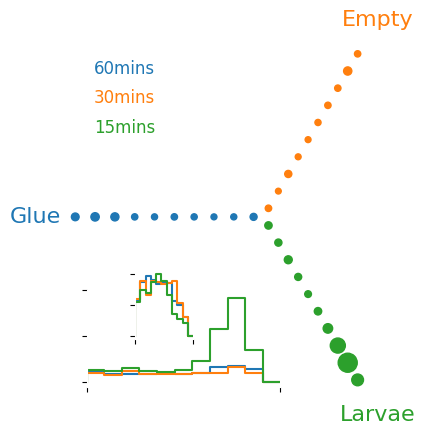

In [86]:
coords = np.concatenate(ALL_COORDS['glue vs nothing vs larvae'])
dt = 1/(5*60) # 5*60 fpm
N = len(ALL_COORDS['glue vs nothing vs larvae'])
coordinate_histogram(coords, dt, N, ids=['Glue', 'Empty', 'Larvae'], figsize=(5,5), save_path=['figures/antsymaze/coordinate_histogram_GNL.pdf', 'figures/antsymaze/coordinate_histogram_GNL.png'], show_velocity=True)

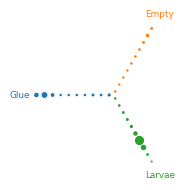

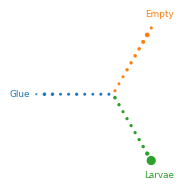

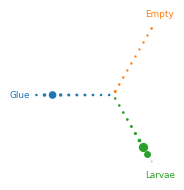

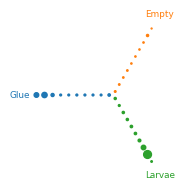

/media/DATA01/Rishika/ANTsYMaze/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/media/DATA01/Rishika/ANTsYMaze/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


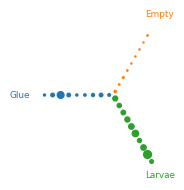

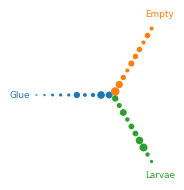

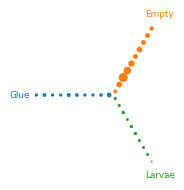

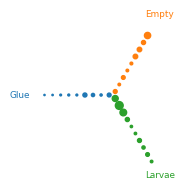

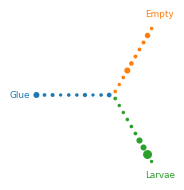

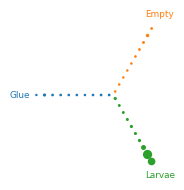

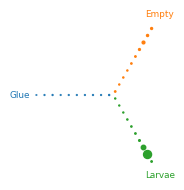

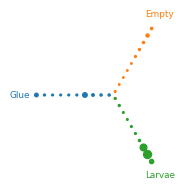

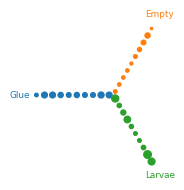

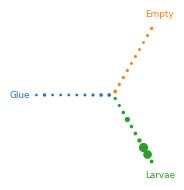

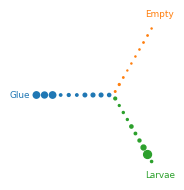

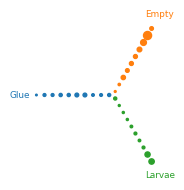

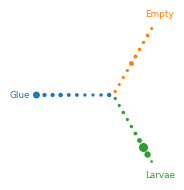

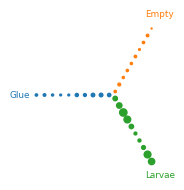

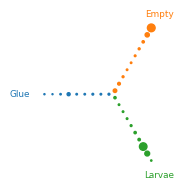

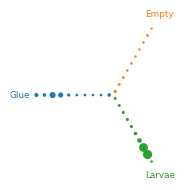

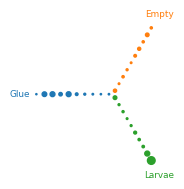

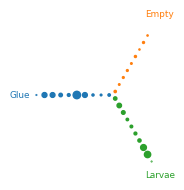

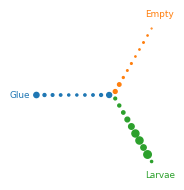

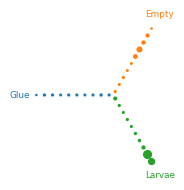

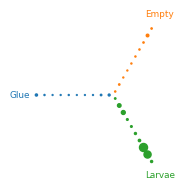

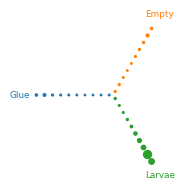

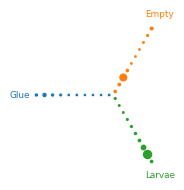

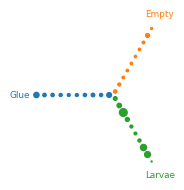

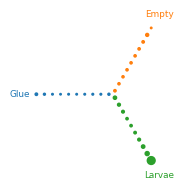

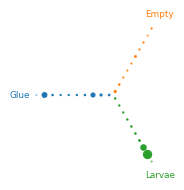

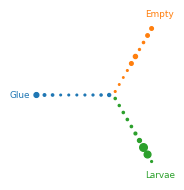

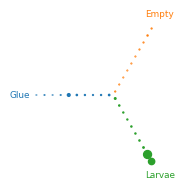

In [87]:
for i in range(len(ALL_COORDS['glue vs nothing vs larvae'])):
    coords = ALL_COORDS['glue vs nothing vs larvae'][i]
    dt = 1/(5*60) # 5*60 fpm per 32 animals 
    coordinate_histogram(coords, dt, 1, ids=['Glue', 'Empty', 'Larvae'], figsize=(2,2),show_legend=False, plot_hist=False, save_path=f'figures/antsymaze/GNL/coordinate_histogram_{i}.png')

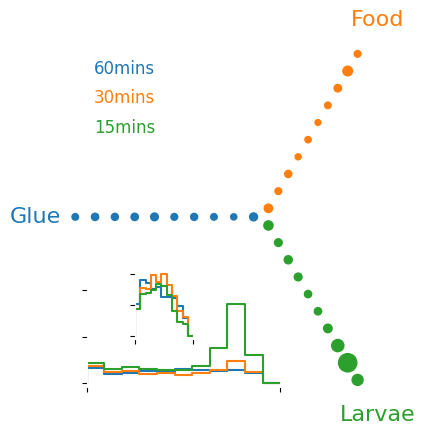

In [88]:
coords = np.concatenate(ALL_COORDS['glue vs food vs larvae'])
dt = 1/(5*60)
N = len(ALL_COORDS['glue vs food vs larvae'])
coordinate_histogram(coords, dt, N, ids=['Glue', 'Food', 'Larvae'], figsize=(5,5), save_path=['figures/antsymaze/coordinate_histogram_GFL.pdf', 'figures/antsymaze/coordinate_histogram_GFL.png'],show_velocity=True)

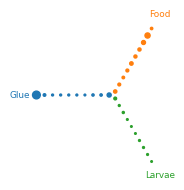

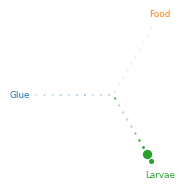

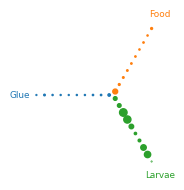

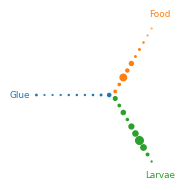

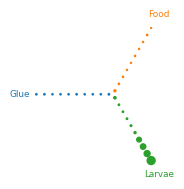

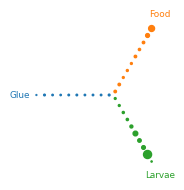

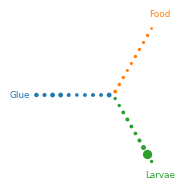

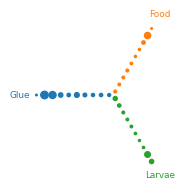

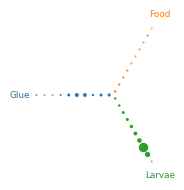

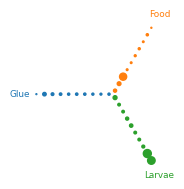

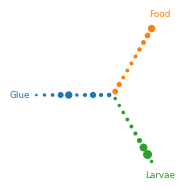

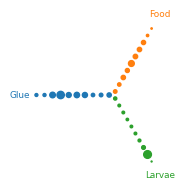

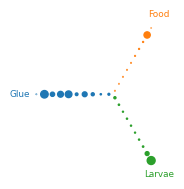

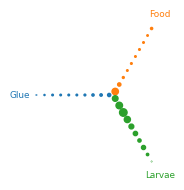

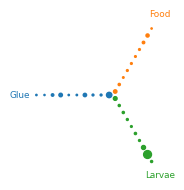

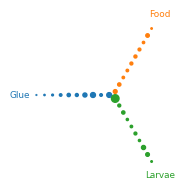

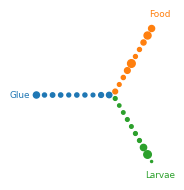

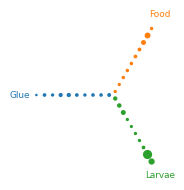

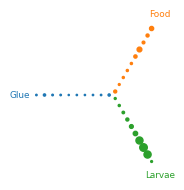

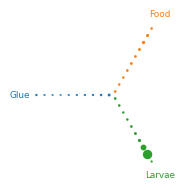

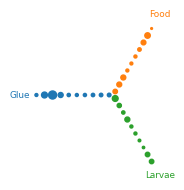

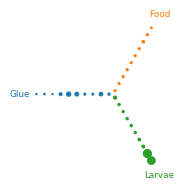

/media/DATA01/Rishika/ANTsYMaze/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/media/DATA01/Rishika/ANTsYMaze/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


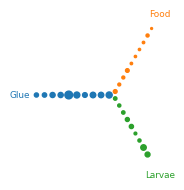

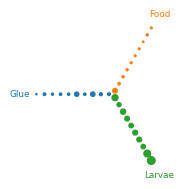

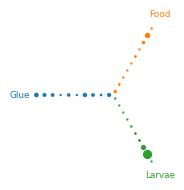

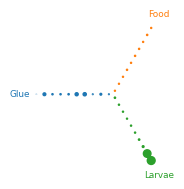

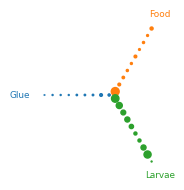

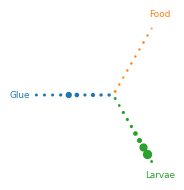

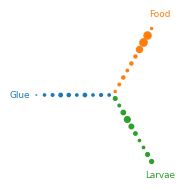

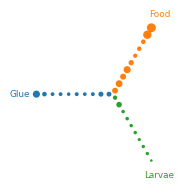

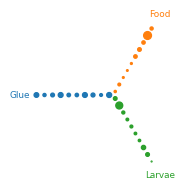

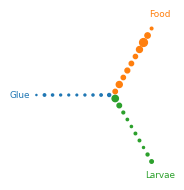

In [89]:
for i in range(len(ALL_COORDS['glue vs food vs larvae'])):
    coords = ALL_COORDS['glue vs food vs larvae'][i]
    dt = 1/(5*60) # 5*60 fpm per 32 animals 
    coordinate_histogram(coords, dt, 1, ids=['Glue', 'Food', 'Larvae'], figsize=(2,2),show_legend=False, plot_hist=False, save_path=f'figures/antsymaze/GFL/coordinate_histogram_{i}.png')

In [90]:
def coordinate_timeseries(coords, dt, ids=None, show_legend=True, figsize=(20,2),save_path=None):
    arm1 = coords[:,0]
    arm1[arm1==0] = np.nan
    arm2 = coords[:,1]
    arm2[arm2==0] = np.nan
    arm3 = coords[:,2]
    arm3[arm3==0] = np.nan
    time = np.arange(0, len(arm1))*dt
    fig,ax = plt.subplots(1,1,figsize=figsize)
    ax.plot(time, arm1, color=plt.cm.tab10(0.0), label=ids[0])
    ax.plot(time, arm2, color=plt.cm.tab10(0.1), label=ids[1])
    ax.plot(time, arm3, color=plt.cm.tab10(0.2), label=ids[2])
    ax.set_xlabel('time (min)')
    ax.set_ylabel('arm (a.u.)')
    ax.set_xlim([time[0], time[-1]])
    ax.legend(loc = 'center right', bbox_to_anchor=(1.15, 0.5), frameon=False)
    # remove figure background
    fig.patch.set_visible(False)
    # remove axis background
    for ax in fig.axes:
        ax.patch.set_visible(False)
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    plt.box(False)
    plt.tight_layout()
    if save_path is not None:
        if type(save_path) == str:
            # make dir if not exist
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            plt.savefig(save_path, transparent=True)
        elif type(save_path) == list:
            for path in save_path:
                # make dir if not exist
                os.makedirs(os.path.dirname(path), exist_ok=True)
                plt.savefig(path, transparent=True)
    plt.show()


('Camera 1', 'Exp C', 'Arena 1')


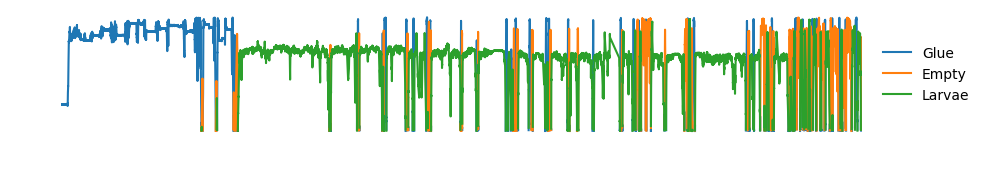

('Camera 1', 'Exp C', 'Arena 2')


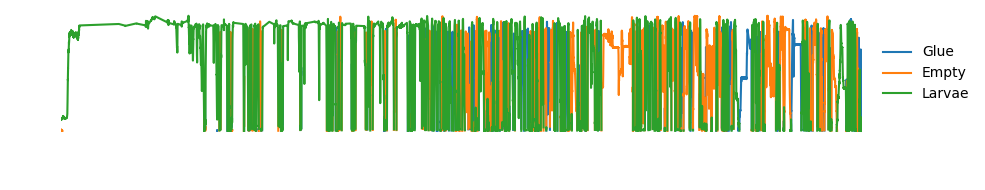

('Camera 1', 'Exp C', 'Arena 3')


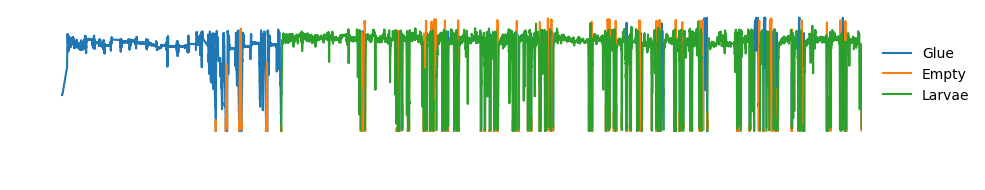

('Camera 1', 'Exp C', 'Arena 4')


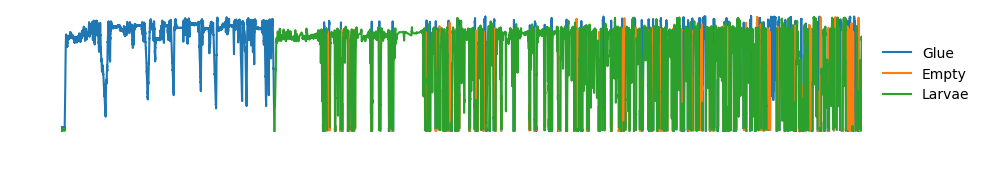

('Camera 1', 'Exp C', 'Arena 5')


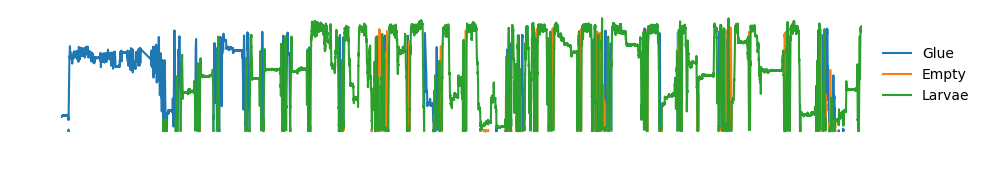

('Camera 1', 'Exp C', 'Arena 6')


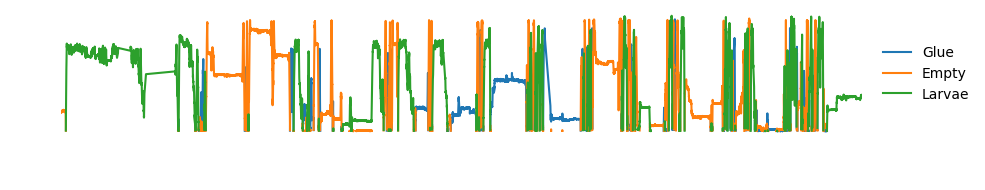

('Camera 1', 'Exp C', 'Arena 7')


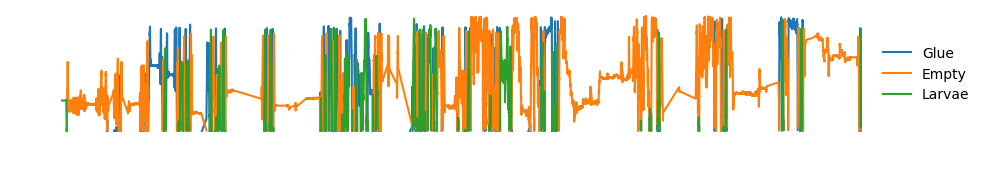

('Camera 1', 'Exp C', 'Arena 8')


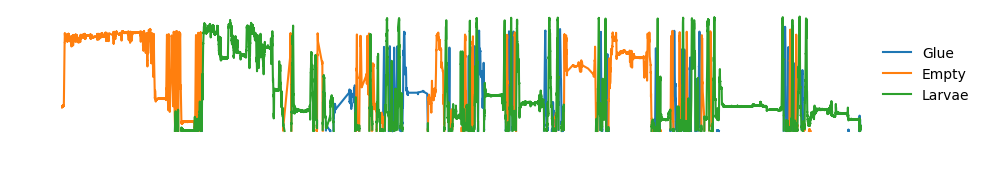

('Camera 2', 'Exp B', 'Arena 1')


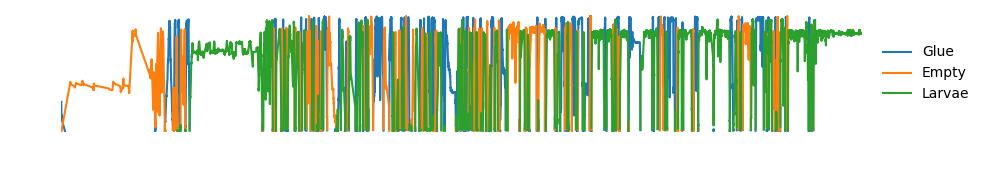

('Camera 2', 'Exp B', 'Arena 2')


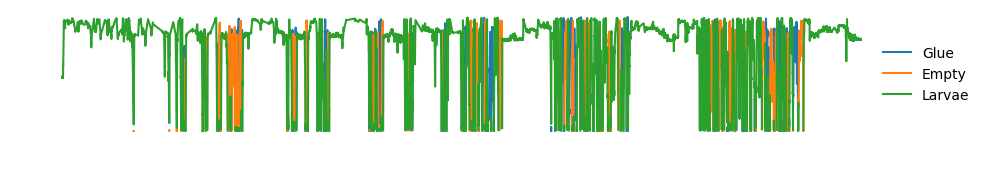

('Camera 2', 'Exp B', 'Arena 3')


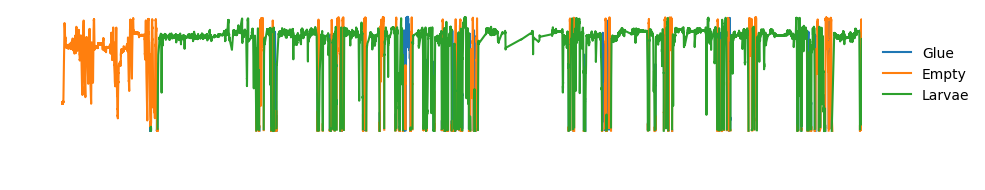

('Camera 2', 'Exp B', 'Arena 4')


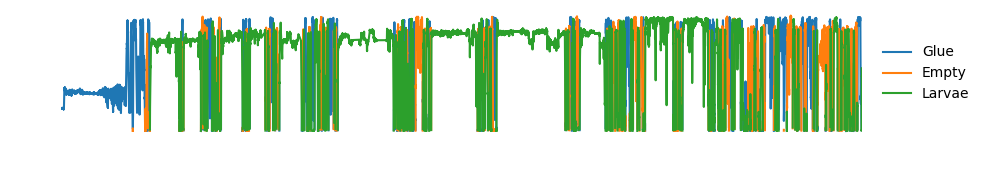

('Camera 2', 'Exp B', 'Arena 5')


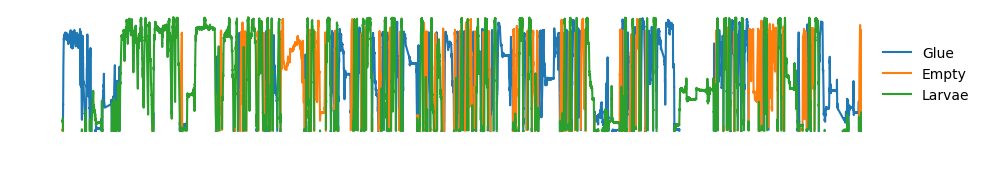

('Camera 2', 'Exp B', 'Arena 6')


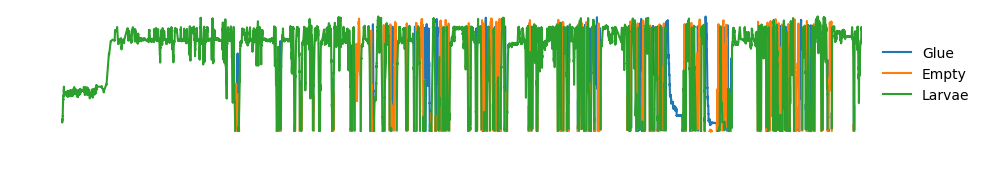

('Camera 2', 'Exp B', 'Arena 7')


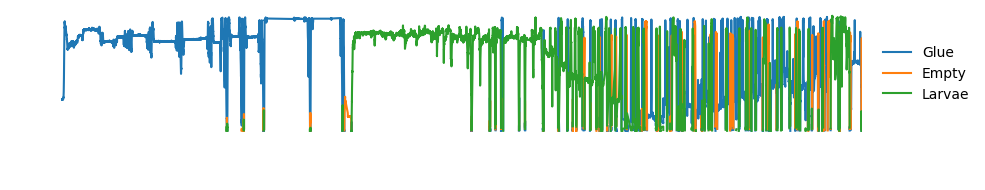

('Camera 2', 'Exp B', 'Arena 8')


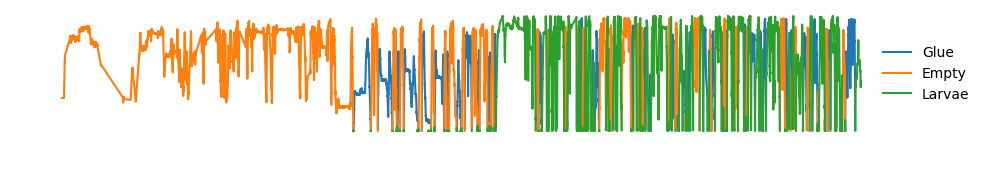

('Camera 4', 'Exp D', 'Arena 1')


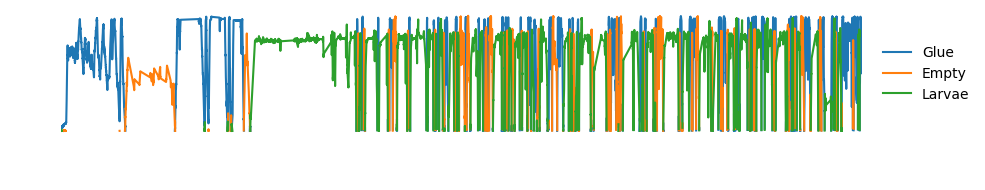

('Camera 4', 'Exp D', 'Arena 2')


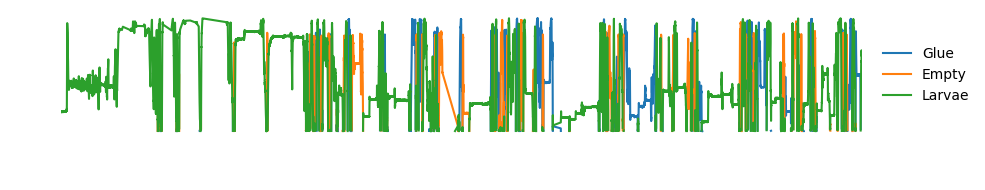

('Camera 4', 'Exp D', 'Arena 3')


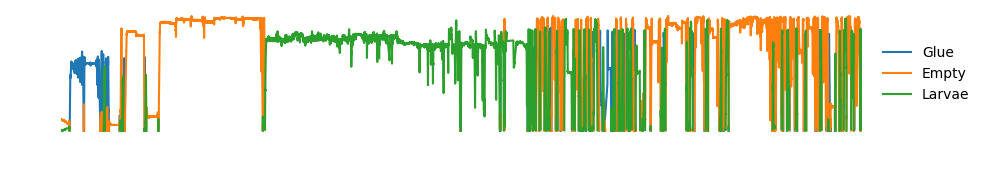

('Camera 4', 'Exp D', 'Arena 4')


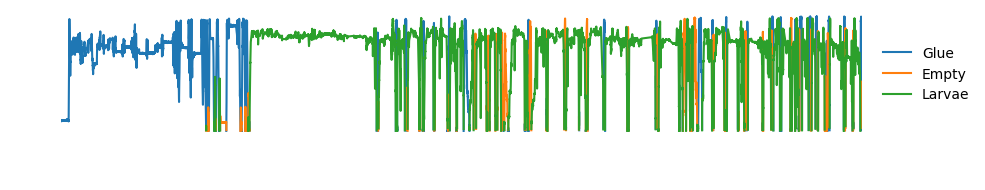

('Camera 4', 'Exp D', 'Arena 5')


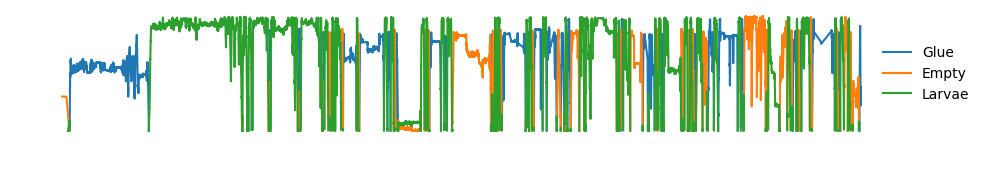

('Camera 4', 'Exp D', 'Arena 6')


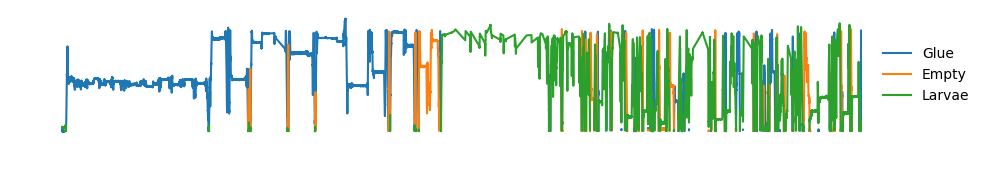

('Camera 4', 'Exp D', 'Arena 7')


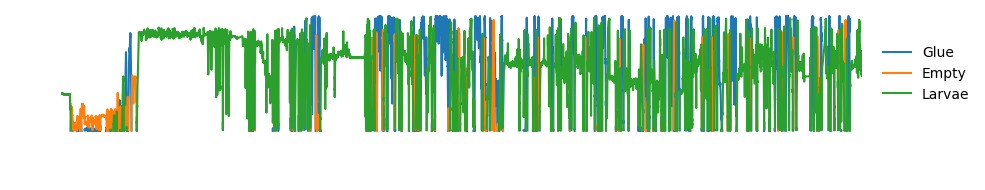

('Camera 4', 'Exp D', 'Arena 8')


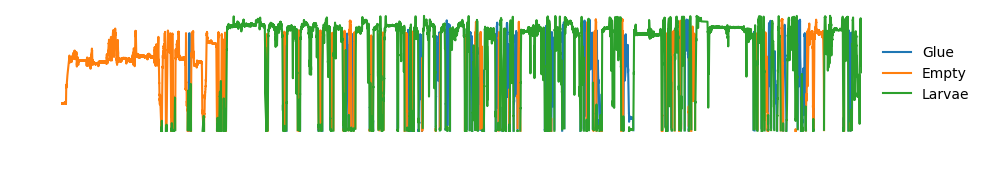

('Camera 5', 'Exp A', 'Arena 1')


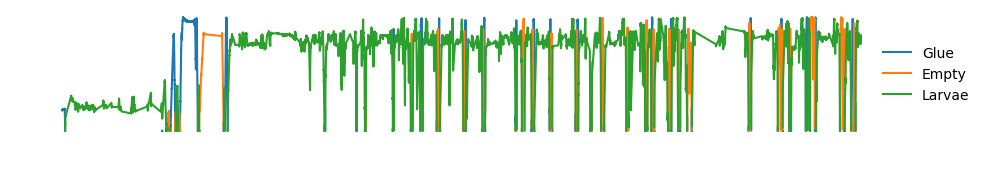

('Camera 5', 'Exp A', 'Arena 2')


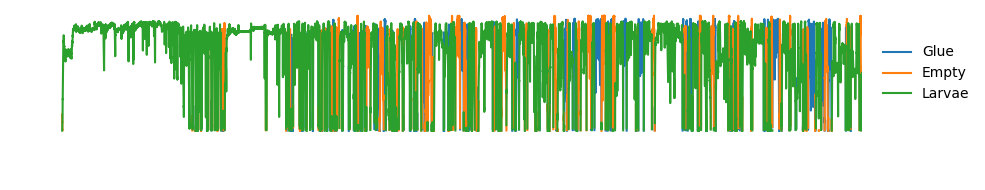

('Camera 5', 'Exp A', 'Arena 3')


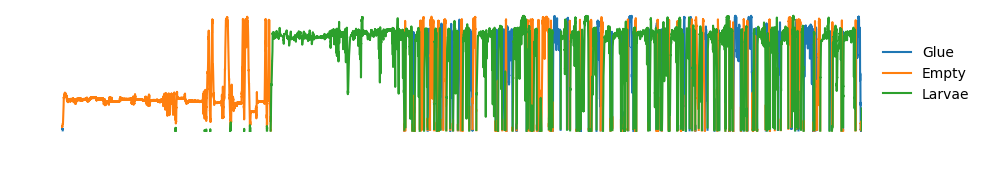

('Camera 5', 'Exp A', 'Arena 4')


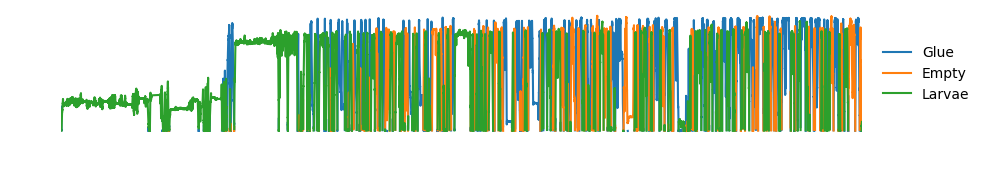

('Camera 5', 'Exp A', 'Arena 5')


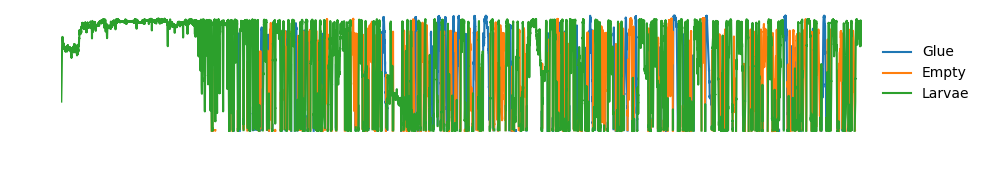

('Camera 5', 'Exp A', 'Arena 6')


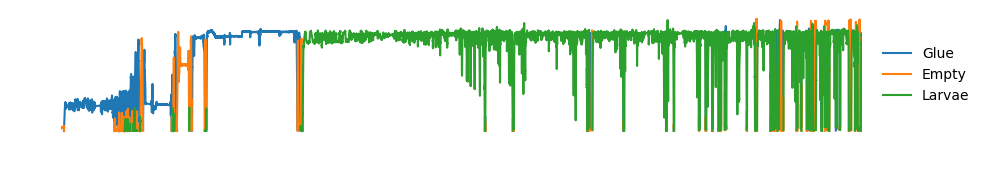

('Camera 5', 'Exp A', 'Arena 7')


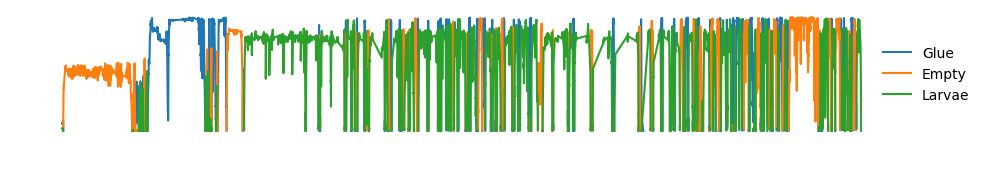

('Camera 5', 'Exp A', 'Arena 8')


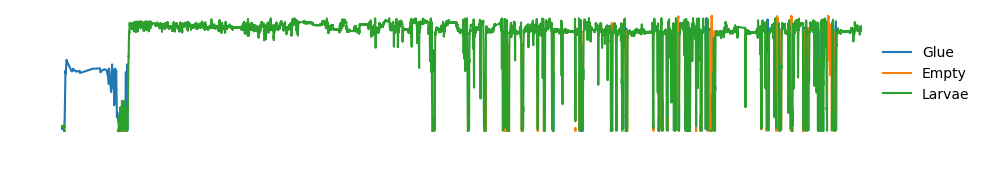

In [91]:
for i in range(len(ALL_COORDS['glue vs nothing vs larvae'])):
    coords = ALL_COORDS['glue vs nothing vs larvae'][i]
    dt = 1/(5*60) # 5*60 fpm
    print(ALL_IDS['glue vs nothing vs larvae'][i])
    coordinate_timeseries(coords, dt, ids=['Glue', 'Empty', 'Larvae'], figsize=(10,2), save_path=f'figures/antsymaze/GNL/coordinate_timeseries_{i}.png')


('Camera 0', 'Exp H', 'Arena 1')


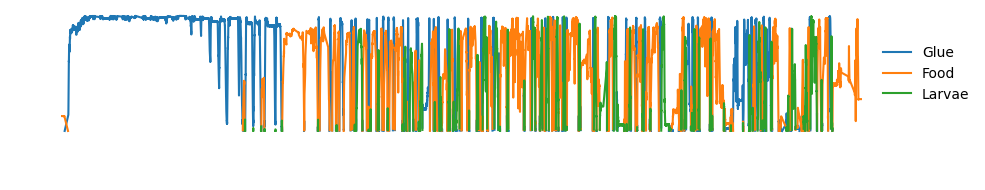

('Camera 0', 'Exp H', 'Arena 2')


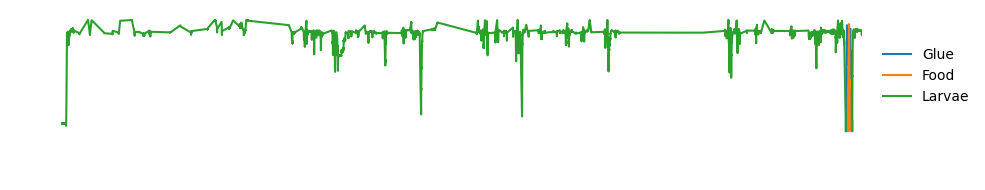

('Camera 0', 'Exp H', 'Arena 3')


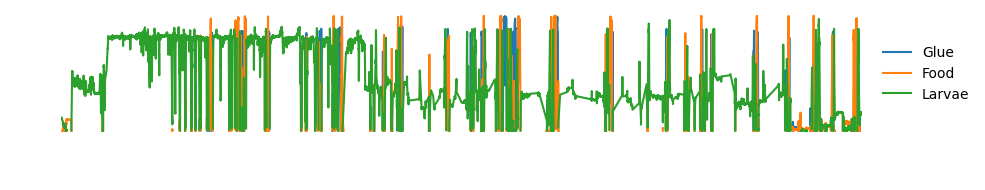

('Camera 0', 'Exp H', 'Arena 4')


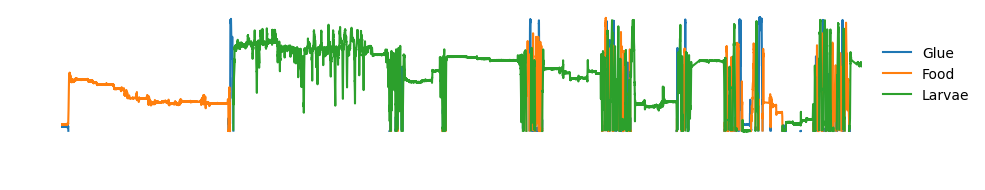

('Camera 0', 'Exp H', 'Arena 5')


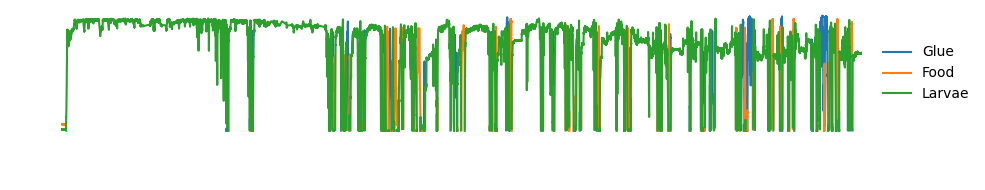

('Camera 0', 'Exp H', 'Arena 6')


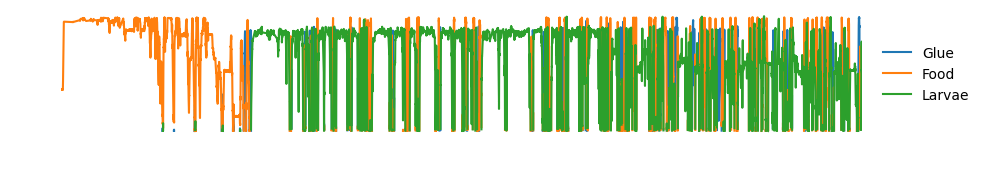

('Camera 0', 'Exp H', 'Arena 7')


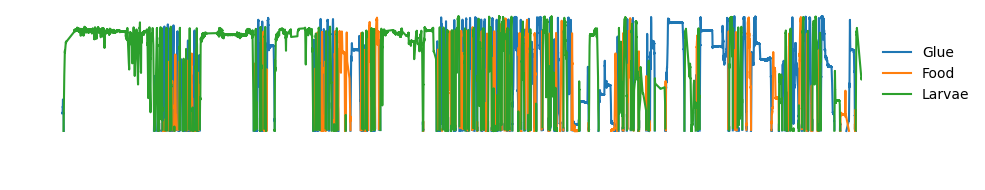

('Camera 0', 'Exp H', 'Arena 8')


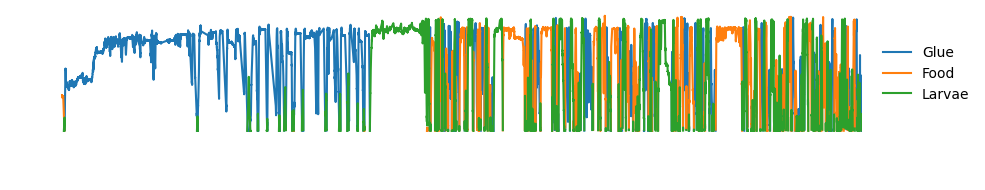

('Camera 3', 'Exp E', 'Arena 1')


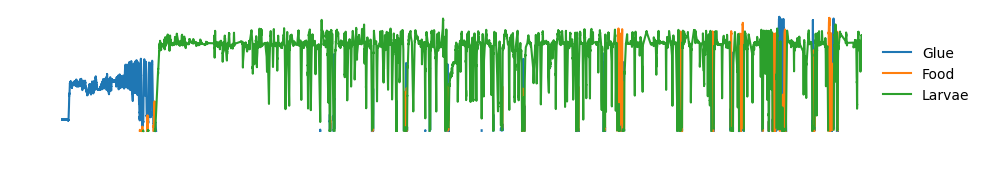

('Camera 3', 'Exp E', 'Arena 2')


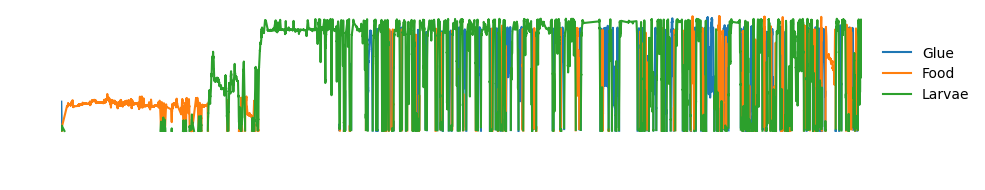

('Camera 3', 'Exp E', 'Arena 3')


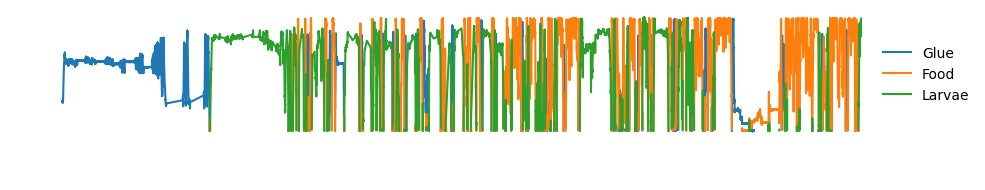

('Camera 3', 'Exp E', 'Arena 4')


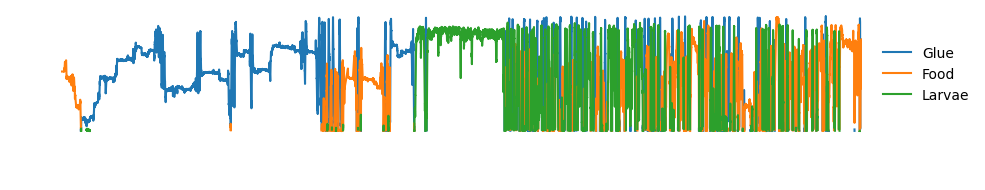

('Camera 3', 'Exp E', 'Arena 5')


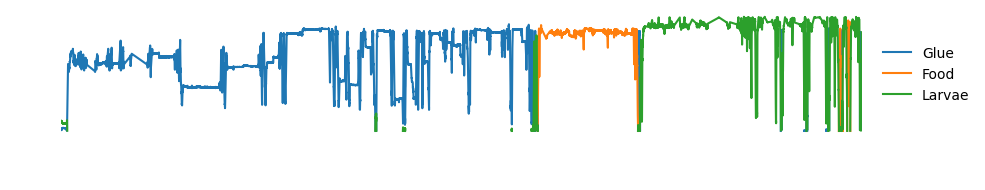

('Camera 3', 'Exp E', 'Arena 6')


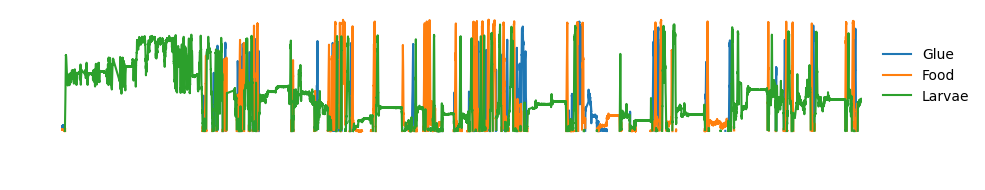

('Camera 3', 'Exp E', 'Arena 7')


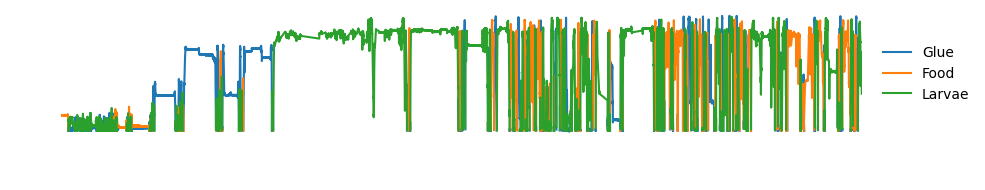

('Camera 3', 'Exp E', 'Arena 8')


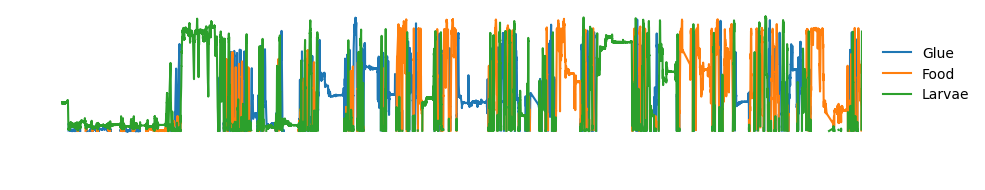

('Camera 6', 'Exp F', 'Arena 1')


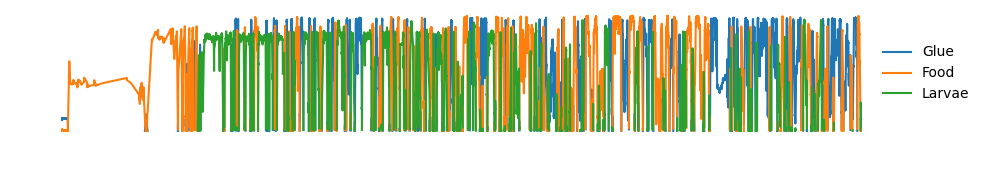

('Camera 6', 'Exp F', 'Arena 2')


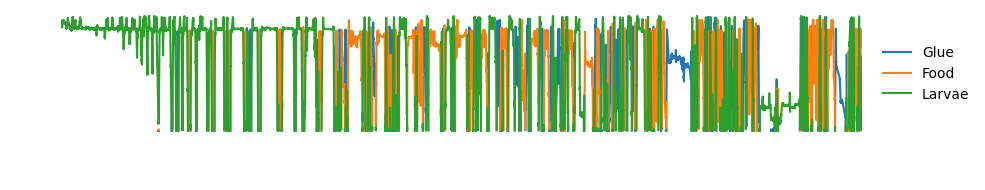

('Camera 6', 'Exp F', 'Arena 3')


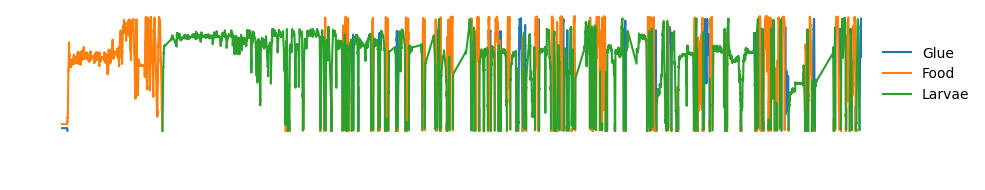

('Camera 6', 'Exp F', 'Arena 4')


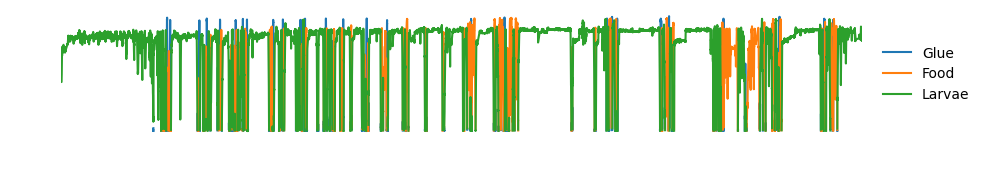

('Camera 6', 'Exp F', 'Arena 5')


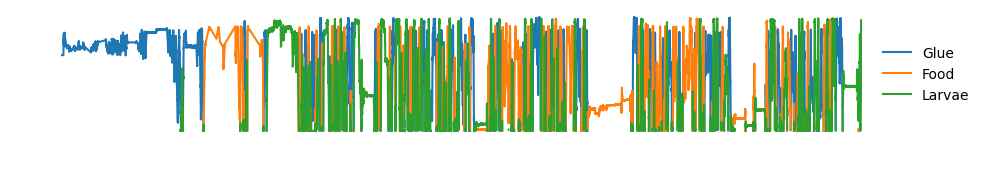

('Camera 6', 'Exp F', 'Arena 6')


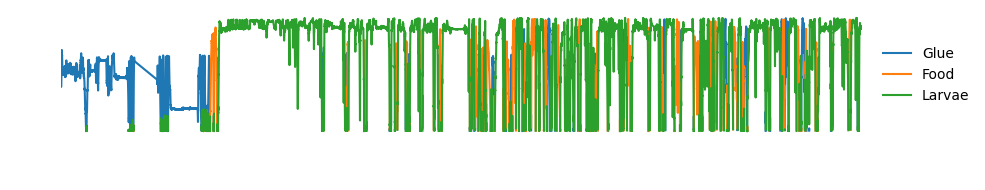

('Camera 6', 'Exp F', 'Arena 7')


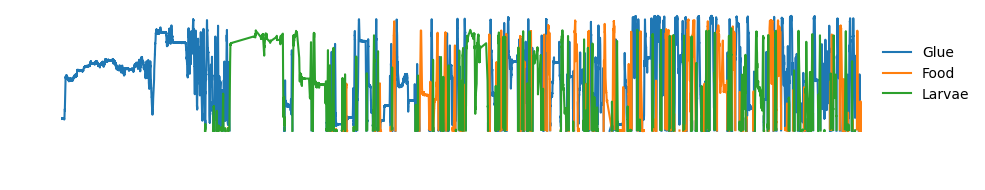

('Camera 6', 'Exp F', 'Arena 8')


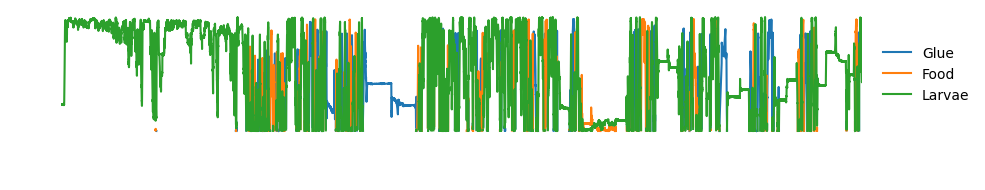

('Camera 7', 'Exp G', 'Arena 1')


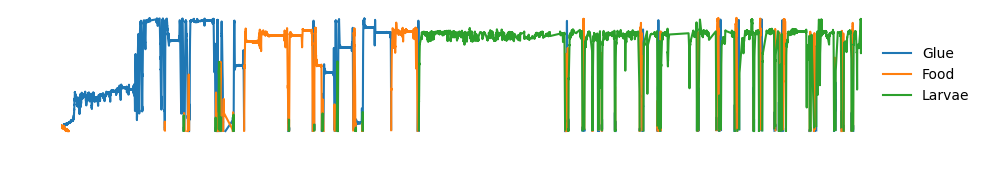

('Camera 7', 'Exp G', 'Arena 2')


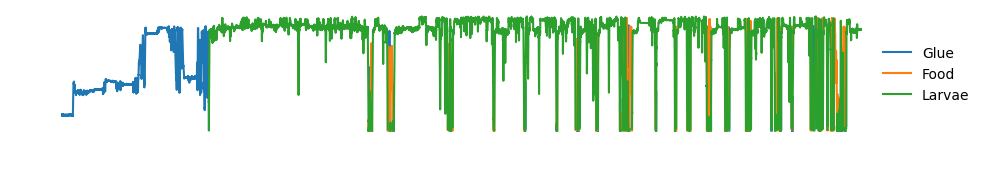

('Camera 7', 'Exp G', 'Arena 3')


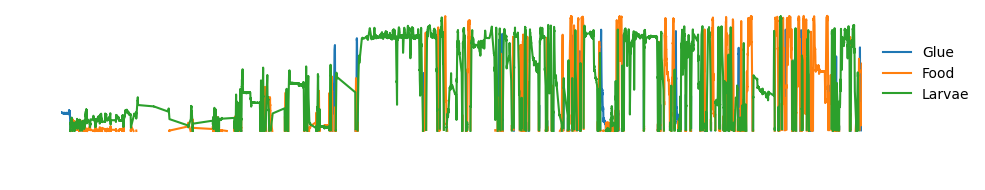

('Camera 7', 'Exp G', 'Arena 4')


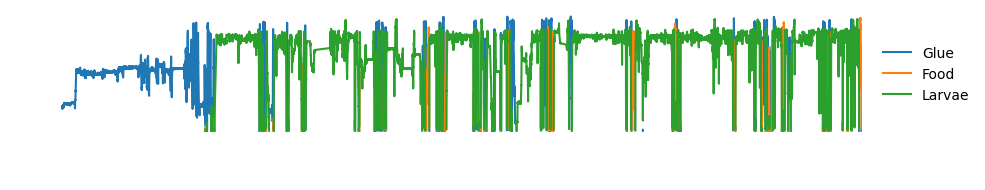

('Camera 7', 'Exp G', 'Arena 5')


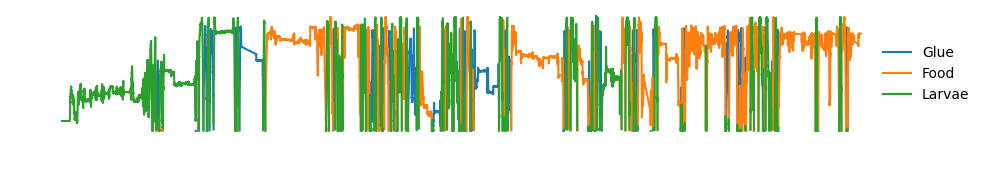

('Camera 7', 'Exp G', 'Arena 6')


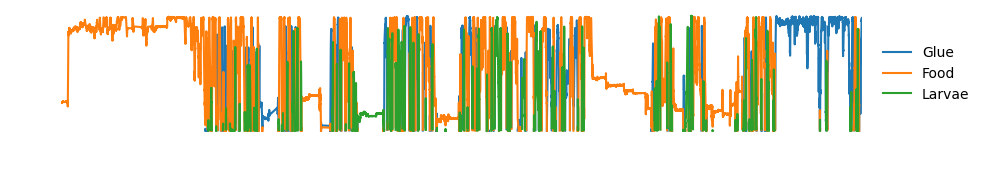

('Camera 7', 'Exp G', 'Arena 7')


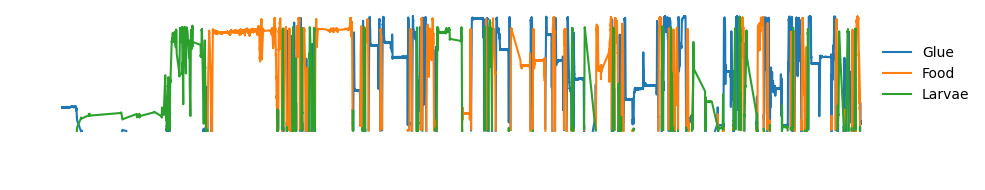

('Camera 7', 'Exp G', 'Arena 8')


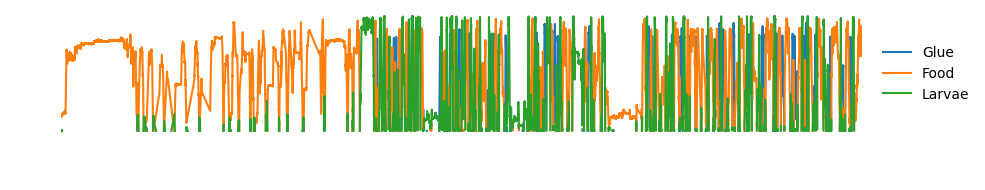

In [92]:
for i in range(len(ALL_COORDS['glue vs food vs larvae'])):
    coords = ALL_COORDS['glue vs food vs larvae'][i]
    dt = 1/(5*60) # 5*60 fpm
    print(ALL_IDS['glue vs food vs larvae'][i])
    coordinate_timeseries(coords, dt, ids=['Glue', 'Food', 'Larvae'], figsize=(10,2), save_path=f'figures/antsymaze/GFL/coordinate_timeseries_{i}.png')
